<a href="https://colab.research.google.com/github/asdflazaro/Cow_Science_Robots/blob/main/C%C3%B3digoProntoDoutorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

▶ **Imports iniciais**

In [110]:
#Baixar e instalar o skopt
!pip install scikit-learn==0.24.2 -q -U
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [111]:
#Import primário
import numpy as np
import pandas as pd
import skopt

▶ **Leitura dos dados**

In [112]:
# Ler a tabela e definir ; como delimitador de colunas
dados = pd.read_csv('Tabela.P.D.csv', delimiter = ';')
dados.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:01,11130,7025,7761,-2178,-1819,2134,1
2,27/01/2023,04:45:02,10120,6610,10145,-2487,185,1868,1
3,27/01/2023,04:45:03,13629,3053,7777,-837,-4725,-3067,1
4,27/01/2023,04:45:04,13537,3296,7080,1245,-2580,571,1


In [113]:
# Visualização do número de colunas e linhas
dados.shape

(78621, 9)

▶ **Treinamento e validação**

In [132]:
# Imports necessários
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

In [133]:
# Revisão das colunas e o tipo
dados.columns

Index(['Data', 'Hora', 'ax', 'ay', 'az', 'gx', 'gy', 'gz ', 'Comportamento'], dtype='object')

In [134]:
# Lista com os atributos aplicáveis (excluindo as colunas não aplicáveis)
features_aplicaveis = 'ax','ay','az','gx','gy', 'gz '

Função para imprimir a quantidade de dados por conjunto

In [135]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [136]:
# Seleciona os dados x (variáveis) e y (comportamento)
x = dados[variaveis]
y = dados['Comportamento']

In [137]:
# Seleciona os dados para treinamento e validação. Teste_size 0.3 define 30% para validação
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=0)

In [138]:
# Visualizar quantos dados vão ser destinados para treinamento e quantos para validação
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  55034
Teste:  23587
-------------------------------------------


Quantidades de dados por classes (Comportamento e Variáveis)

In [139]:
# Qtd de dados por comportamento
y_train.value_counts(normalize=True)*100

1    59.703093
2    40.296907
Name: Comportamento, dtype: float64

In [140]:
# Qtd de dados por variáveis (Acc e Giroscópio)
y_test.value_counts(normalize=True)*100

1    59.040997
2    40.959003
Name: Comportamento, dtype: float64

In [141]:
# Import de funções para treinamento e validação
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

Matriz de confusão

In [142]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [143]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

▶ **LGBMClassifier - Light Gradient Boosting**

In [144]:
# Import para LGB
from lightgbm import LGBMClassifier

In [145]:
# Acurácia antes da busca por hiperparametro
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

90.31669987705092

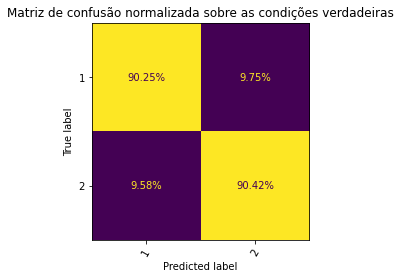

In [146]:
# Imprimir a matriz de confusão
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [147]:
# Imprimir tabela de precisão, sensibilidade e F1-Score
print(classification_report(y_test, lgb_preds))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92     13926
           2       0.87      0.90      0.88      9661

    accuracy                           0.90     23587
   macro avg       0.90      0.90      0.90     23587
weighted avg       0.90      0.90      0.90     23587



LGB: Busca de melhores hiper parâmetros

In [148]:
def tune_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100, n_jobs=-1)
    
    auc = cross_val_score(lgb_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

Busca pelo melhor hiperparametro

In [149]:
%%time
resultados_lgb = gp_minimize(tune_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 433, 429, 0.8548891518449193, 0.6612073271073752] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.0555
Function value obtained: -0.8829
Current minimum: -0.8829
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 154, 29, 0.30902347985110756, 0.529898605589215] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.4364
Function value obtained: -0.8735
Current minimum: -0.8829
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 247, 197, 0.8442748253605089, 0.40365654437554166] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.1836
Function value obtained: -0.8907
Current minimum: -0.8907
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 190, 479, 0.1833332413920129, 0.8830785325225929] 

Iteration No: 4 ended. Evaluation done at random point.

In [151]:
# Retorna o melhor hiperparametro
resultados_lgb.x

[0.1, 512, 1, 1.0, 1.0]

LGB: Treinamento com os melhores hiper parâmetros

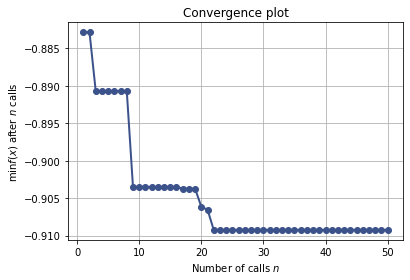

In [154]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

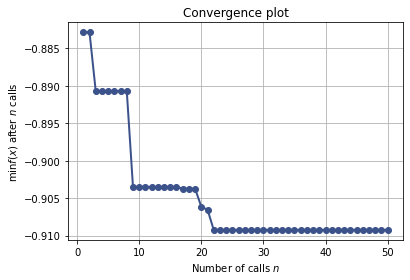

In [155]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

In [157]:
# Treinamento com o melhor hiperparametro - É necessário inserir manualmente
%%time
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=1.0, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

CPU times: user 10.6 s, sys: 200 ms, total: 10.8 s
Wall time: 8.63 s


90.97384152287276

In [183]:
############################## classification_report_extendido (y_test, lgb_preds)

In [167]:
# Tabela com precisão, sensitividade, f1-Score e acurácia
print(classification_report(y_test, lgb_preds, digits=3))

              precision    recall  f1-score   support

           1      0.931     0.915     0.923     13926
           2      0.881     0.901     0.891      9661

    accuracy                          0.910     23587
   macro avg      0.906     0.908     0.907     23587
weighted avg      0.910     0.910     0.910     23587



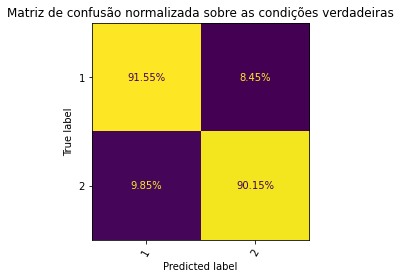

In [168]:
# Imprimir tabela de confusão
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [169]:
# Acurácia após hiperparametro
lgb_preds = lgb_model.predict(X_train)

accuracy_score(y_train, lgb_preds)*100

99.96365882908748

▶ **RF - Random Forest**

In [173]:
# Importar o pacote para RF
from sklearn.ensemble import RandomForestClassifier

In [172]:
# Definir o modelo
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [174]:
# Criação do grig de parametros
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [175]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [191]:
# Busca por parametros
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*a

CPU times: user 17.2 s, sys: 1.89 s, total: 19.1 s
Wall time: 49.3 s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [50, 100, 150, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10, 30, 50],
                                        'n_estimators': array([ 50, 100, 150, 200])},
                   random_state=0, verbose=1)

In [192]:
# Retorna os melhores parâmetros
rf_RandomGrid.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': False}

In [193]:
####### Não to conseguindo entender aqui
rf_RandomGrid.best_score_

nan

In [179]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [180]:
# Retorna a acurácia do modelo
accuracy_score(y_test, preds_rf_RG)*100

90.92720566413702

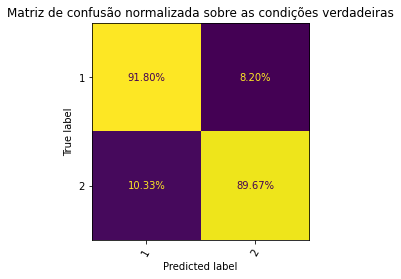

In [181]:
# Imprime a matriz de confusão
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

Busca de melhores hiper parâmetros

In [187]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [189]:
######### Não funcinou
# %%time
# from skopt import forest_minimize
# resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.8546
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.0592
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.1278
Function value obtained: nan
Current minimum: nan
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.2928
Function value obtained: nan
Current minimum: nan
Iteration No: 5 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 5, 1, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.0609
Function value obtained: nan
Current minimum: nan
Iteration No: 6 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 4.1608
Function value obtained: nan
Current minimum: nan
Iteration No: 7 started. Evaluating function at random point.
[50, 'sqrt', 150, 'entropy', 5, 4, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.3157
Function value obtained: nan
Current minimum: nan
Iteration No: 8 started. Evaluating function at random point.
[100, 'auto', 150, 'gini', 30, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.1973
Function value obtained: nan
Current minimum: nan
Iteration No: 9 started. Evaluating function at random point.
[150, 'auto', 100, 'gini', 5, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.3679
Function value obtained: nan
Current minimum: nan
Iteration No: 10 started. Evaluating function at random point.
[150, 'sqrt', 150, 'entropy', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.2345
Function value obtained: nan
Current minimum: nan
Iteration No: 11 started. Evaluating function at random point.
[200, 'sqrt', 50, 'entropy', 2, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 4.3487
Function value obtained: nan
Current minimum: nan
Iteration No: 12 started. Evaluating function at random point.
[100, 'auto', 150, 'gini', 50, 1, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.1305
Function value obtained: nan
Current minimum: nan
Iteration No: 13 started. Evaluating function at random point.
[200, 'sqrt', None, 'gini', 2, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 4.2044
Function value obtained: nan
Current minimum: nan
Iteration No: 14 started. Evaluating function at random point.
[200, 'sqrt', None, 'entropy', 10, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

Iteration No: 14 ended. Evaluation done at random point.
Time taken: 4.2461
Function value obtained: nan
Current minimum: nan
Iteration No: 15 started. Evaluating function at random point.
[100, 'auto', 150, 'gini', 5, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args

ValueError: ignored

In [197]:
########## Não funcinou pq o anterior não funcionou
# resultado_rf.x

NameError: ignored

In [196]:
########### Não funcinou pq o anterior não funcionou
# from skopt.plots import plot_convergence
# plot_convergence(resultado_rf)

NameError: ignored

RF: Treinamento com os melhores hiper parâmetros

In [198]:
# Não tem os melhores hiperparametros pq a procura não funcionou
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy',
                                  min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 45.1 s, sys: 164 ms, total: 45.2 s
Wall time: 28.7 s


In [199]:
# Acurácia com os melhores hiperparametros
accuracy_score(y_test, preds)*100

91.07983211090855

In [200]:
######## Classificação extendida também não funcionou aqui - Perguntar do Caio
# classification_report_extendido(y_test, preds)

KeyError: ignored

In [201]:
# Tabela com precisão, sensitividade, f1-Score e acurácia
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

           1      0.931     0.916     0.924     13926
           2      0.882     0.903     0.892      9661

    accuracy                          0.911     23587
   macro avg      0.907     0.910     0.908     23587
weighted avg      0.911     0.911     0.911     23587



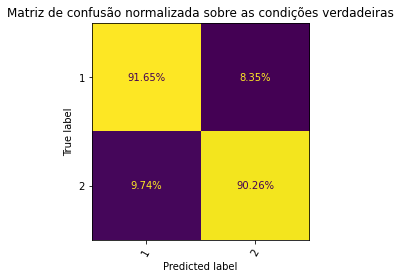

In [202]:
# Retorna a matriz de confusão
imprimeMatrizDeConfusão(y_test, preds, rf_model)

In [203]:
# Acurácia após hiperparametro
rf_preds = rf_model.predict(X_train)

accuracy_score(y_train, rf_preds)*100

96.98004869716902